Welcome to the clustering notebook!

This notebook is a follow-up to the [Pileups and average features](https://cooltools.readthedocs.io/en/latest/notebooks/pileup_CTCF.html) notebook. 
Here, we will show how one can use unsupervised clustering methods to expore the heterogenity of patterns within one pileup. 

In this notebook we:
* generate snippets as in [Pileups and average features](https://cooltools.readthedocs.io/en/latest/notebooks/pileup_CTCF.html) notebook. 
* follow the steps of image clustering analysis 


Content: 

1. Download data
2. Load data
    - Load cooler and genomic regions
    - Load and filter features for anchors 
3. Generate on-diagonal pileup of Obs/Exp Hi-C interactions
4. Inspect the snippets 
5. Cluster the snippets  
    - Pre-processing of snippets: blurring 
    - Pre-processing of snippets: replacing missing values and standardizing
    - Embedding using UMAP
    - Clustering
6. Explore the results of clustering
    - Generate a pileup for each cluster
    - Explore the heterogenity within each cluster
7. Acknowledgement

In [1]:
# import standard python libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

In [2]:
# import libraries for biological data analysis
import cooler
import cooltools
import cooltools.lib.plotting
from cooltools import insulation
import bioframe as bf
import bbi

from packaging import version
if version.parse(cooltools.__version__) < version.parse('0.5.1'):
    raise AssertionError("tutorials rely on cooltools version 0.5.1 or higher,"+
                         "please check your cooltools version and update to the latest")

In [3]:
# import libraries for image processing and cluster analysis 
import skimage
import scipy
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.cluster import AgglomerativeClustering
import umap
import umap.plot

In [4]:
# a function to find diagonal indices to set these values to nan
def kth_diag_indices(a, k):
    rows, cols = np.diag_indices_from(a)
    if k < 0:
        return rows[-k:], cols[:k]
    elif k > 0:
        return rows[:-k], cols[k:]
    else:
        return rows, cols

In [5]:
# a function to plot snippets
def make_plot(ax, snippet) :
    c = ax.imshow(snippet, vmin = -0.8, vmax = 0.8, cmap='coolwarm', interpolation='none')
    f.colorbar(c, ax = ax, fraction=0.046, label = 'log2 (Obs/Exp)')
    ticks_pixels = np.linspace(0, flank_clr*2//resolution,5)
    ticks_kbp = ((ticks_pixels-ticks_pixels[-1]/2)*resolution//1000).astype(int)
    ax.set_xticks(ticks_pixels, ticks_kbp)
    ax.set_yticks(ticks_pixels, ticks_kbp)
    ax.set_xlabel('relative position, kbp')
    ax.set_ylabel('relative position, kbp')
    return ax

# Load data

In this notebook, we will be using the same data sets as in [Pileups and average features](https://cooltools.readthedocs.io/en/latest/notebooks/pileup_CTCF.html) notebook. Namely, Micro-C data from [immortalized human foreskin fibroblast cell line HFFc6](https://data.4dnucleome.org/ontology-terms/EFO:0009318/):

* Micro-C data from [Krietenstein *et al*. 2020](https://pubmed.ncbi.nlm.nih.gov/32213324/)

As a first step, we will download this data set directly from cooltools.

In [6]:
cool_file = cooltools.download_data("HFF_MicroC", cache=True, data_dir='./')

In [7]:
# Load a Hi-C map at a 10kb resolution from a cooler file.
resolution = 10000
clr = cooler.Cooler('./test.mcool::/resolutions/'+str(resolution))

In [8]:
# Use bioframe to fetch the genomic features from the UCSC.
hg38_chromsizes = bf.fetch_chromsizes('hg38')
hg38_cens = bf.fetch_centromeres('hg38')
# Create a view with chromosome arms using chromosome sizes 
# and definition of centromeres
hg38_arms = bf.make_chromarms(hg38_chromsizes,  hg38_cens)
# Select only those chromosomes available in cooler
hg38_arms = hg38_arms[hg38_arms.chrom.isin(clr.chromnames)].reset_index(drop=True)
hg38_arms

,chrom,start,end,name
0,chr2,0,93139351,chr2_p
1,chr2,93139351,242193529,chr2_q
2,chr17,0,24714921,chr17_p
3,chr17,24714921,83257441,chr17_q


## Generate features for anchors 

Middlepoints of TAD boundaries will be the anchors of our Micro-C snippets. 

In [9]:
windows = [5*resolution]
insulation_table = insulation(clr, windows, verbose=True)

INFO:root:Processing region chr2
INFO:root:Processing region chr17


In [10]:
boundaries = insulation_table[~np.isnan(insulation_table[f'boundary_strength_{windows[0]}'])]
strong_boundaries = boundaries[boundaries[f'is_boundary_{5*resolution}']]
strong_boundaries = strong_boundaries.iloc[:,:3]

In [11]:
strong_boundaries['mid'] = (strong_boundaries.end + strong_boundaries.start)//2

# Generate on-diagonal pileup of Obs/Exp Hi-C interactions

Now we are ready to compute a TAD centered pileup of Micro-C data. Here, we will use observed-over-expected values. For more information, please refer to [Pileups and average features](https://cooltools.readthedocs.io/en/latest/notebooks/pileup_CTCF.html) notebook. 

In [12]:
# Calculate the expected values for chromosome arms
expected = cooltools.expected_cis(clr, view_df=hg38_arms, nproc=2, chunksize=1_000_000)

In [13]:
# Define the size of flanks around each TAD boundary
flank_clr = 500000
# Compute snippets for the pileup 
stack = cooltools.pileup(clr, strong_boundaries, view_df=hg38_arms,
                         expected_df=expected, flank=flank_clr)
# Aggregate snippets into a pileup
mtx = np.nanmean(stack, axis=0)

/tmp/ipykernel_7371/3512439402.py:7: RuntimeWarning: Mean of empty slice
  mtx = np.nanmean(stack, axis=0)


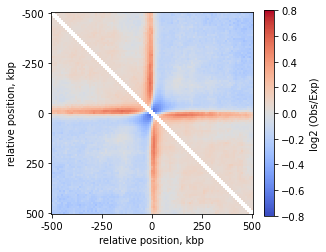

In [14]:
f,ax = plt.subplots(figsize=(4, 4)) 
make_plot(ax, np.log2(mtx))
plt.show();

# Inspect snippets

Aggregation into pileups neglects the heterogenity within the data set. Let's look at a few snippets from our data set and compare them to the pattern of the pileup. 

In [15]:
# select snippets we want to look at 
number = np.array ([[43, 20, 95], [100, 45, 169]])

/tmp/ipykernel_7371/1062560732.py:7: RuntimeWarning: divide by zero encountered in log2
  make_plot(ax, np.log2(stack[number[i,j]]))


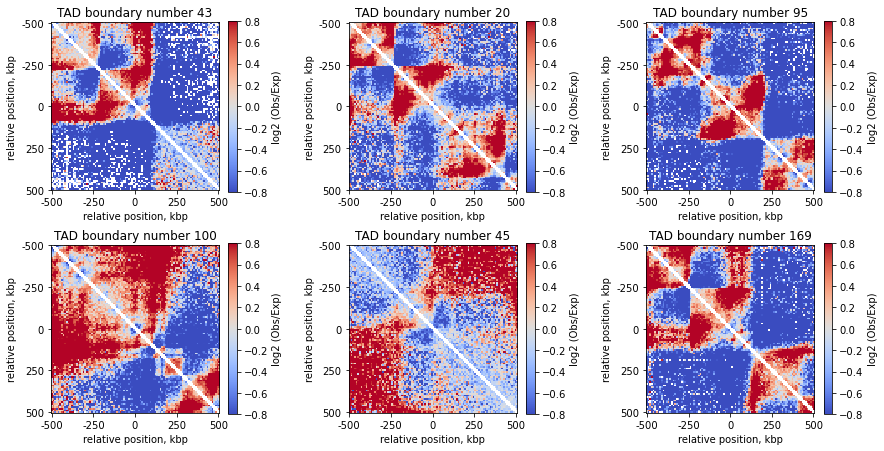

In [16]:
f,axs = plt.subplots(figsize=(14, 7.5), nrows=2, ncols=3)
plt.subplots_adjust(wspace=0.6)

for i in range (2): 
    for j in range (3): 
        ax = axs [i,j]
        make_plot(ax, np.log2(stack[number[i,j]]))
        ax.set_title (f'TAD boundary number {number[i,j]}')

From this selection of snippets we can conclude that the genome-wide patterns centered at TAD boundaries are quite diverse. Let's try to stratify all snippets into groups.  

# Cluster the snippets 

## Pre-processing of snippets: blurring

Our images do not require much pre-processing since they have the same size, colorscale and pixel values range. Yet, since Micro-C data can be sparse, we suggest an optional step of blurring the images prior to embedding. 

First, we will test the blurring parameters using one random snippet.

In [17]:
# set the sigma of the blurring kernel (you can try different values) 
blurring_kernel_sigma = 1
# select a random snippet 
number = random.choice(range(0, 614))

In [18]:
image = np.nan_to_num(np.log2(stack[number]), neginf=0, posinf=0)
# blur the snippet
blurred_image = skimage.filters.gaussian(image,
                blurring_kernel_sigma,
                mode = "constant",
                cval=0.0)
# set the values in the first two diagonals to 0. 
for l in range(-1, 2):
    blurred_image[kth_diag_indices(blurred_image, l)] = np.nan

/tmp/ipykernel_7371/91227497.py:1: RuntimeWarning: divide by zero encountered in log2
  image = np.nan_to_num(np.log2(stack[number]), neginf=0, posinf=0)


/tmp/ipykernel_7371/3452955649.py:4: RuntimeWarning: divide by zero encountered in log2
  make_plot(ax, np.log2(stack[number]))


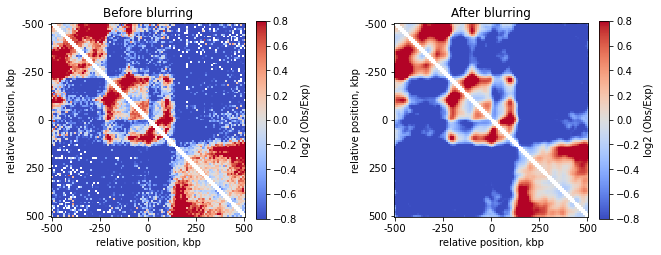

In [19]:
f,axs = plt.subplots(figsize=(10, 4.2), nrows=1, ncols=2)
plt.subplots_adjust(wspace=0.6)
ax = axs [0]
make_plot(ax, np.log2(stack[number]))
ax.set_title (f'Before blurring');

ax = axs [1]
make_plot(ax, blurred_image)
ax.set_title (f'After blurring');

We are satisfied with the output of blurring and we we will now blur all snippets.  

In [20]:
blurred_stack = []

for image in stack:
    image = np.nan_to_num(np.log2(image), neginf=0, posinf=0)
    blurred_image = skimage.filters.gaussian(
                    image,
                    blurring_kernel_sigma, 
                    mode = "constant",
                    cval=0.0)
    # blank the first two diagonals
    for l in range(-1, 2):
        blurred_image[kth_diag_indices(blurred_image, l)] = np.nan
    # append each blurred image to the list
    blurred_stack.append(blurred_image.flatten())
    
# make a numpy stack from the list
blurred_stack = np.stack(blurred_stack)

/tmp/ipykernel_7371/512736255.py:4: RuntimeWarning: divide by zero encountered in log2
  image = np.nan_to_num(np.log2(image), neginf=0, posinf=0)


## Pre-processing of snippets: replacing missing values and standardizing 

Irrespetively of whether you performed blurring or not, the following steps must be done prior to embedding: 

* replacing missing data with the mean value of the image 
* standardizing the data (removing the mean and variance scaling)

In [21]:
# replace missing values with the mean value of the image 
imputed = SimpleImputer().fit_transform(blurred_stack)

In [22]:
# Standardize features by removing the mean and scaling to unit variance.
scaled = StandardScaler().fit_transform(imputed)

## Embedding using UMAP

We will use Uniform Manifold Approximation and Projection (UMAP) to reduce dimensionality of our dataset (this process is called embedding). For more information about embedding, you can refer to [Google’s Machine Learning Crash Course](https://developers.google.com/machine-learning/crash-course/embeddings/video-lecture) or many other good online resources. 

Please note, that here we will use UMAP with already optimized parameters: n_neighbours = 20 and min_dist = 0. To keep this notebook relatively short, we omitted showing the optimization steps, yet we refer the reader to the wonderfully written [UMAP documentation](https://umap-learn.readthedocs.io/en/latest/parameters.html), where you can find how one can do it. 

In [23]:
embedder = umap.UMAP(random_state=42, n_neighbors=20, min_dist=0.0)
embedding = embedder.fit_transform(scaled)

## Clustering

We will use agglomerative clustering in this example. It worked well for our dataset, yet it is by no means the only or the best clustering method. [Google's machine learning course](https://developers.google.com/machine-learning/clustering/clustering-algorithms) will provide you with more clustering methods to try out with your dataset.

In [24]:
# set the number of clusters to 3. This number was determined empirically for our dataset.
# please consider changing it based on your embedding results
number_clusters = 4
model = AgglomerativeClustering(distance_threshold=None, n_clusters=number_clusters)
pred_y = model.fit_predict(embedding)

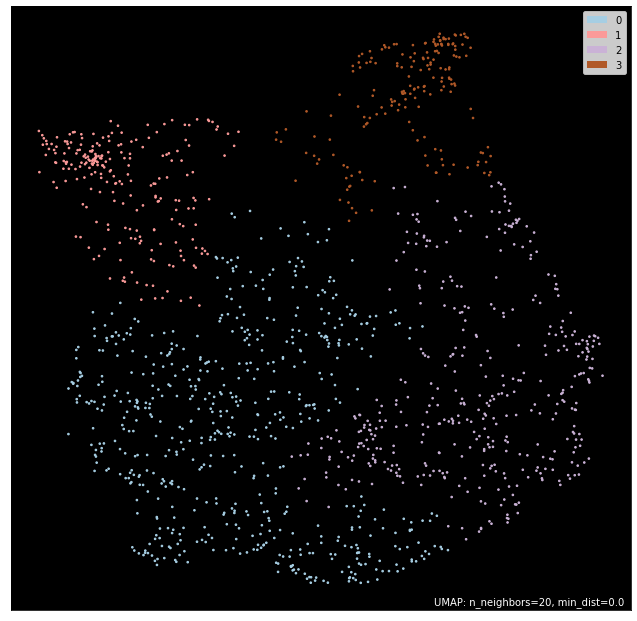

In [25]:
# plot the results
plot = umap.plot.points(embedder.fit(scaled),
                        labels=pred_y,
                        color_key_cmap='Paired',
                        background='black')

# Explore the results of clustering

## Generate a pileup for each cluster 

In [26]:
# add cluster identifier to each TAD boundary
strong_boundaries['cluster_label'] = pred_y

/tmp/ipykernel_7371/83248962.py:12: RuntimeWarning: Mean of empty slice
  mtx = np.nanmean(stack, axis=0)


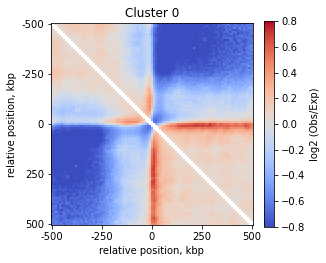

/tmp/ipykernel_7371/83248962.py:12: RuntimeWarning: Mean of empty slice
  mtx = np.nanmean(stack, axis=0)


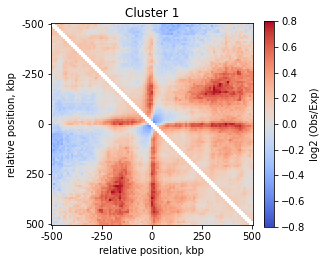

/tmp/ipykernel_7371/83248962.py:12: RuntimeWarning: Mean of empty slice
  mtx = np.nanmean(stack, axis=0)


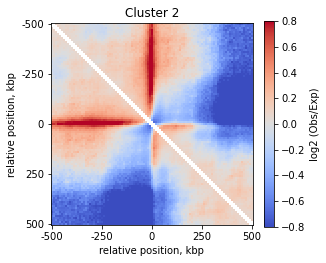

/tmp/ipykernel_7371/83248962.py:12: RuntimeWarning: Mean of empty slice
  mtx = np.nanmean(stack, axis=0)


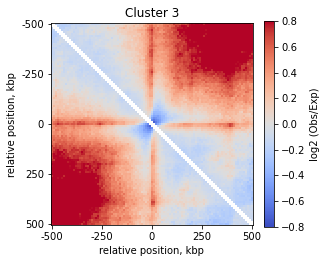

In [27]:
# plot a pileup for each cluster
for i in range (number_clusters):
    # select TAD boundaries belonging to the same cluster
    cluster = strong_boundaries[strong_boundaries.cluster_label == i]
    # generate a stack of snippets
    stack = cooltools.pileup(clr, 
                             cluster, 
                             view_df=hg38_arms, 
                             expected_df=expected, 
                             flank=flank_clr)
    # aggregate snippets into a pileup
    mtx = np.nanmean(stack, axis=0)
    # plot the matrix 
    f,ax = plt.subplots(figsize=(4, 4)) 
    make_plot(ax, np.log2(mtx))
    ax.set_title (f"Cluster {i}")
    
    plt.show();

Our clustering allowed us to identify different sub-groups of Hi-C patterns around TAD boundaries. The sub-groups differ from each other by the directionaly of stripes and by the strength of insultation. 

# Acknowledgements

The authors want to thank [HiCognition](https://www.biorxiv.org/content/10.1101/2022.04.30.490134v1) developers, [Christoph Langer](https://github.com/cchlanger) and [Michael Mitter](https://github.com/Mittmich), for their idea to implement clustering methods for the exploration of Hi-C data and for their comments on this notebook.  